# Supervised machine learning for stock price prediction and technical analysis for generating buy and sell signals

this example is quite basic and may need further refinement for practical use. Also, you'll need to implement the calculate_rsi function to calculate the Relative Strength Index (RSI), as it's used as a feature in the model. Additionally, you may want to experiment with different machine learning models, hyperparameters, and features to improve the forecasting accuracy.

In [12]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf

#Library to fetch historical stock data from Yahoo Finance.
from sklearn.model_selection import train_test_split

#A machine learning model used for regression tasks.
from sklearn.ensemble import RandomForestRegressor

#A function to evaluate the performance of the regression model.
from sklearn.metrics import mean_squared_error

#Library for creating visualizations.
import matplotlib.pyplot as plt

### This function calculates the Relative Strength Index (RSI), a momentum indicator used in technical analysis.

   - delta = close.diff(): Calculates the difference between consecutive closing prices.
   - gain: Calculates the rolling mean of gains.
   - loss: Calculates the rolling mean of losses.
   - rs = gain / loss: Calculates the relative strength.
   - rsi = 100 - (100 / (1 + rs)): Converts the relative strength into RSI values.

In [13]:
# Define the function to calculate Relative Strength Index (RSI)
def calculate_rsi(close, window):
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

### Fetching Historical Stock Price Data

   - ticker: Symbol for the stock.
   - yf.download(): Fetches historical stock price data for the specified ticker and date range.

In [21]:
# Fetching historical stock price data for a Thai stock
ticker = 'SHR.BK'  
data = yf.download(ticker, start='2010-01-01', end='2022-01-01')

[*********************100%%**********************]  1 of 1 completed


### Feature Engineering

Calculates the 50-day and 200-day Simple Moving Averages (SMA) and the 14-day RSI.
   - rolling(window=50).mean(): Computes the rolling mean over the specified window size.

In [22]:
# Feature Engineering
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()
data['RSI'] = calculate_rsi(data['Close'], window=14)

### Drop missing values and unnecessary columns and Splitting Data

   - dropna(): Removes rows with missing values.
   - drop(): Removes specified columns that are not needed for the analysis.
   - X: Features used for training the model (SMA50, SMA200, RSI).
   - y: Target variable (closing prices).
   - Splits the dataset into training (80%) and testing (20%) sets.
   - random_state=42: Ensures reproducibility by setting a random seed.

In [23]:
# Drop missing values and unnecessary columns
data.dropna(inplace=True)
data.drop(['Open', 'High', 'Low', 'Volume', 'Adj Close'], axis=1, inplace=True)

# Splitting the data into features and target variable
X = data.drop(['Close'], axis=1)
y = data['Close']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Training the Random Forest Regressor model

   - RandomForestRegressor: Initializes the Random Forest model with 100 trees.
   - fit(): Trains the model using the training data.
   - predict(): Makes predictions on the test data.
   - mean_squared_error(): Calculates the mean squared error between the actual and predicted values.

In [24]:
# Training the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Making predictions on the test set
predictions = rf_regressor.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.004112592214121047


### Forecasting

   -   pd.date_range(): Generates future dates.
   - Prepares a DataFrame for future data and fills it with the last available values from the historical data.
   - predict(): Forecasts future prices using the trained model.

In [25]:
# Forecasting future prices
future_dates = pd.date_range(start='2022-01-02', end='2023-01-01')
future_data = pd.DataFrame(index=future_dates)
future_data['SMA50'] = data['SMA50'].iloc[-1]
future_data['SMA200'] = data['SMA200'].iloc[-1]
future_data['RSI'] = data['RSI'].iloc[-1]

# Filling missing values with last available values
future_data.fillna(method='ffill', inplace=True)
future_forecast = rf_regressor.predict(future_data)

# Creating a DataFrame for the forecasted prices
forecast_df = pd.DataFrame(index=future_dates)
forecast_df['Forecast'] = future_forecast

### Generating Signal

   - Generates buy and sell signals based on the forecasted and actual prices.
   - np.where(): Creates buy and sell signals (1 for buy/sell, 0 otherwise).

In [26]:
# Generate signals based on forecast
def generate_signals(data, actual_prices):
    signals = pd.DataFrame(index=data.index)
    signals['Forecast'] = data['Forecast']
    actual_prices_reindexed = actual_prices.reindex(data.index, method='ffill')
    signals['Actual'] = actual_prices_reindexed['Close']
    signals['Buy'] = np.where(signals['Forecast'] > signals['Actual'], 1, 0)
    signals['Sell'] = np.where(signals['Forecast'] < signals['Actual'], 1, 0)
    return signals

# Generate signals using historical actual prices as reference
signals_df = generate_signals(forecast_df, data)

### Visualizing

   - Plots the actual and forecasted prices.
   - Marks buy and sell signals with green and red markers respectively.
   - plt.figure(): Sets the figure size.
   - plt.plot(): Plots lines for actual and forecasted prices.
   - plt.scatter(): Plots buy and sell signals.
   - plt.title(), plt.xlabel(), plt.ylabel(), plt.legend(): Adds titles and labels to the plot.

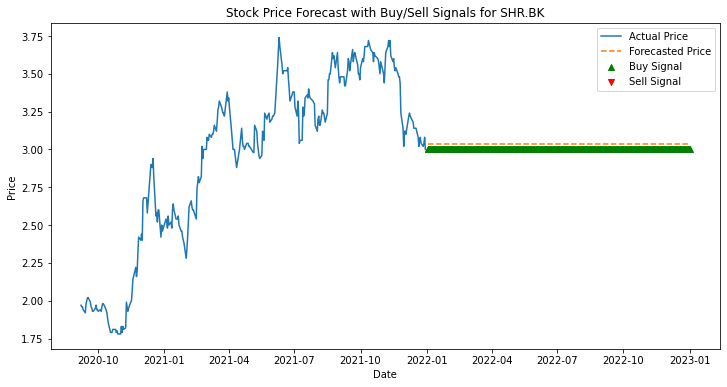

In [27]:
# Visualizing the forecasted prices and signals
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Actual Price')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecasted Price', linestyle='dashed')
plt.scatter(signals_df[signals_df['Buy'] == 1].index, signals_df['Actual'][signals_df['Buy'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(signals_df[signals_df['Sell'] == 1].index, signals_df['Actual'][signals_df['Sell'] == 1], marker='v', color='r', label='Sell Signal')
plt.title('Stock Price Forecast with Buy/Sell Signals for '+ ticker)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()